(10886, 12)
RMSLE : 1.165, RMSE : 140.900, MAE : 105.924
      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


RMSLE : 1.017, RMSE : 162.594, MAE : 109.286
### LinearRegression ###
RMSLE : 0.590, RMSE : 97.688, MAE : 63.382
### Ridge ###
RMSLE : 0.590, RMSE : 98.529, MAE : 63.893
### Lasso ###
RMSLE : 0.635, RMSE : 113.219, MAE : 72.803
### RandomForestRegressor ###
RMSLE : 0.355, RMSE : 50.593, MAE : 31.288
### GradientBoostingRegressor ###
RMSLE : 0.330, RMSE : 53.360, MAE : 32.756
[20:29:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE : 0.345, RMSE : 58.245, MAE : 35.768
### LGBMRegressor ###
RMSLE : 0.319, RMSE : 47.215, MAE : 29.029


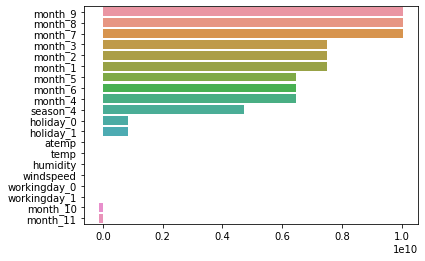

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

bike_df = pd.read_csv('./bike_train.csv')
print(bike_df.shape)
bike_df.head()

# datetime칼럼의 경우 형태가 object이므로, 변환이 필요하다

bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] =  bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head()
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis= 1, inplace = True)

from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y- log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle


def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE : {:.3f}, RMSE : {:.3f}, MAE : {:.3f}'.format(rmsle_val, rmse_val, mae_val))
    

    
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test,pred)


def get_top_error_data(y_test, pred, n_tops = 5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    print(result_df.sort_values('diff',ascending=False)[:n_tops])
    
get_top_error_data(y_test, pred, n_tops=5)
print('\n')

# 차이가 너무 크다. 따라서 count의 값이 정규분포를 따르는지 확인한다.
# y_target.hist()

# 0~200 사이에 분포된 것을 확인할 수 있다.
# log변화를 통해 정규분포형태로 변환한다.

y_log_transform = np.log1p(y_target)
# y_log_transform.hist()

y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size = 0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)

pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

# RMSLE 오류는 줄었지만, RMSE는 늘어났다.

coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
# sns.barplot(x=coef_sort.values, y= coef_sort.index)
# year의 회귀계수값이 매우 높다.
# 이는 카테고리 값이어야할 year값이 숫자형 값으로 되어있어, 발생한 문제이다.
# 하지만 카테고리값으로 변환하면 회귀모델을 적용하지 못하므로, 원-핫 인코딩으로 변환한다.

X_features_ohe = pd.get_dummies(X_features, columns = ['year','month','day','hour','holiday','workingday','season','weather'])

X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size = 0.3, random_state=0)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)
    

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1= True)
    
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)    



# 회귀트리를 이용한 예측

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators = 500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators = 500)


for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)
